# Detecting Fish - Method 2

The goal of this model is to accurately detect which type of fish (if there is one) is in each image. The data is from a Kaggle competition, "The Nature Conservancy Fisheries Monitoring": https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring.

This model is slightly different than model 1. Here we will use a narrower and shallower neural network, and Kfold with 5 splits, instead of an 80-20 train-test split.

In [14]:
import numpy as np
np.random.seed(2)

import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')
import os
import glob
import cv2
import datetime
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from sklearn.cross_validation import KFold
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adagrad, Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from sklearn.metrics import log_loss
from keras import __version__ as keras_version
from sklearn.grid_search import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cross_validation import train_test_split

In [6]:
# The directories where the images are located
train_dir = 'train/'
test_dir = 'test_stg1/'
fish_classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [7]:
# The size of the images we will use to train our model
rows = 64
cols = 64
channels = 3

In [80]:
def get_images(fish):
    """Load files from train folder"""
    fish_dir = train_dir+'{}'.format(fish)
    images = [fish+'/'+im for im in os.listdir(fish_dir)]
    return images

def read_image(src):
    """Read and resize individual images"""
    im = cv2.imread(src, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (cols, rows), interpolation=cv2.INTER_CUBIC)
    return im


files = []
y_all = []

for fish in fish_classes:
    fish_files = get_images(fish)
    files.extend(fish_files)
    
    y_fish = np.tile(fish, len(fish_files))
    y_all.extend(y_fish)
    print("{0} photos of {1}".format(len(fish_files), fish))
        
y_all = np.array(y_all)

1719 photos of ALB
200 photos of BET
117 photos of DOL
67 photos of LAG
465 photos of NoF
299 photos of OTHER
176 photos of SHARK
734 photos of YFT


In [9]:
# Process all of the training images
X_all = np.ndarray((len(files), rows, cols, channels), dtype=np.uint8)

for i, im in enumerate(files): 
    X_all[i] = read_image(train_dir+im)
    if i%100 == 0: print('Processed {} of {}'.format(i, len(files)))

print(X_all.shape)

Processed 0 of 3777
Processed 100 of 3777
Processed 200 of 3777
Processed 300 of 3777
Processed 400 of 3777
Processed 500 of 3777
Processed 600 of 3777
Processed 700 of 3777
Processed 800 of 3777
Processed 900 of 3777
Processed 1000 of 3777
Processed 1100 of 3777
Processed 1200 of 3777
Processed 1300 of 3777
Processed 1400 of 3777
Processed 1500 of 3777
Processed 1600 of 3777
Processed 1700 of 3777
Processed 1800 of 3777
Processed 1900 of 3777
Processed 2000 of 3777
Processed 2100 of 3777
Processed 2200 of 3777
Processed 2300 of 3777
Processed 2400 of 3777
Processed 2500 of 3777
Processed 2600 of 3777
Processed 2700 of 3777
Processed 2800 of 3777
Processed 2900 of 3777
Processed 3000 of 3777
Processed 3100 of 3777
Processed 3200 of 3777
Processed 3300 of 3777
Processed 3400 of 3777
Processed 3500 of 3777
Processed 3600 of 3777
Processed 3700 of 3777
(3777, 64, 64, 3)


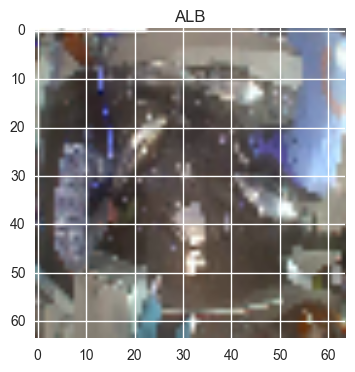

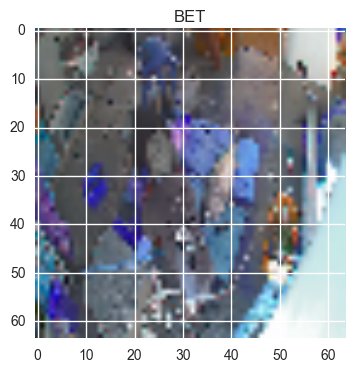

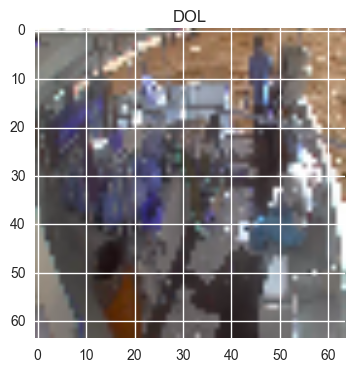

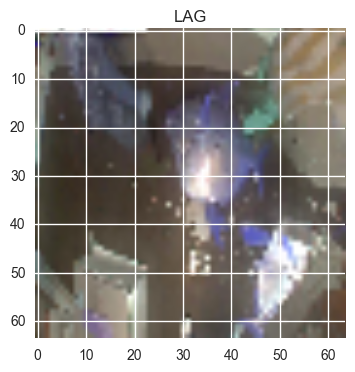

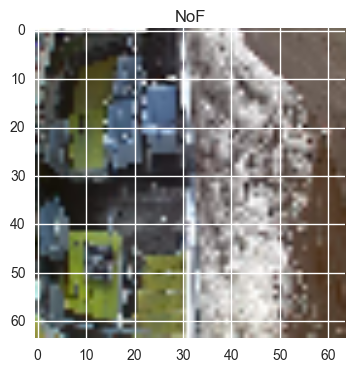

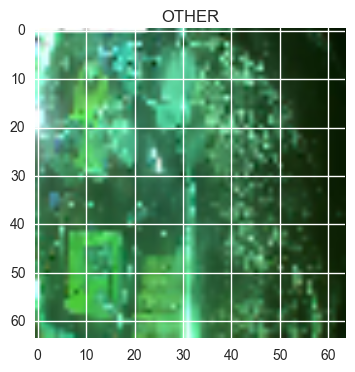

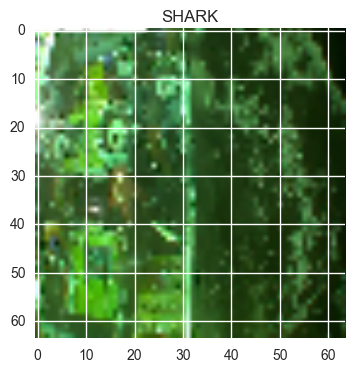

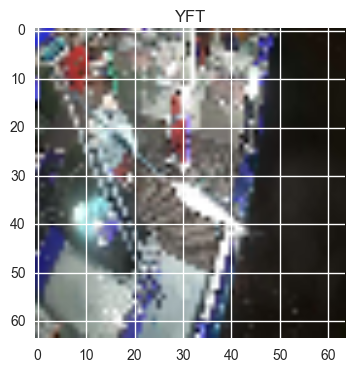

In [12]:
# View a fish from each class
uniq = np.unique(y_all, return_index=True)
for f, i in zip(uniq[0], uniq[1]):
    plt.imshow(X_all[i])
    plt.title(f)
    plt.show()

In [81]:
# One Hot Encoding Labels
y_all = LabelEncoder().fit_transform(y_all)
y_all = np_utils.to_categorical(y_all)

In [16]:
# Normalize the pixel values
X_all = X_all.astype('float32')
X_all = X_all / 255

In [82]:
def cnn_model():
    model = Sequential()
    model.add(Convolution2D(8, 3, 3, border_mode='same', input_shape=(rows, cols, channels), activation='relu'))
    model.add(Convolution2D(8, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(8, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(16, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(16, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(16, 3, 3, border_mode='same', activation='relu'))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(fish_classes), activation='softmax'))

    # The learning rate in this model is higher than in model 1, 0.002 vs 0.001.
    # The model is designed to train faster than model 1.
    sgd = SGD(lr=0.002, decay=5e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics = ['accuracy'])

    return model

In [83]:
# Parameters
batch_size = 32
nb_epoch = 250
random_state = 2
nFolds = 5 

# Transform the images to prevent overfitting.
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    )

# Split the data into the number of folds (nFolds)
kf = KFold(len(X_all), n_folds=nFolds, shuffle=True, random_state=random_state)
num_fold = 0 # Keeps track of the current fold
sum_score = 0 # Keeps track of the total score/log loss
models = [] # Contains the model for each of the folds

for train_index, test_index in kf:
    model = cnn_model()
    x_train = X_all[train_index]
    y_train = y_all[train_index]
    x_valid = X_all[test_index]
    y_valid = y_all[test_index]
    datagen.fit(x_train)

    num_fold += 1
    print('Start KFold number {} from {}'.format(num_fold, nFolds))
    print('Split train:', len(x_train), len(y_train))
    print('Split valid:', len(x_valid), len(y_valid))
 
    # Use EarlyStopping to stop the training when the learning plateaus.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    
    # Transform data and train the model
    model.fit_generator(datagen.flow(x_train, y_train, 
                                     batch_size = batch_size),
                        samples_per_epoch=len(x_train), 
                        nb_epoch = nb_epoch, 
                        verbose = 2,
                        validation_data = (x_valid, y_valid),
                        callbacks = [early_stopping])

    # Make the predictions
    predictions_valid = model.predict(x_valid, verbose=1)
    
    # Record and sum score/log loss
    score = log_loss(y_valid, predictions_valid)
    print('Score log_loss: ', score)
    sum_score += score

    # Store valid predictions
    for i in range(len(test_index)):
        y_all[test_index[i]] = predictions_valid[i]

    models.append(model)

# Average the validation scores from all of the folds.
score = sum_score/nFolds
print("Log_loss avg: ", score)
info_string = 'loss_' + str(score) + '_folds_' + str(nFolds) + '_ep_' + str(nb_epoch)

Start KFold number 1 from 5
Split train: 3021 3021
Split valid: 756 756
Epoch 1/250
38s - loss: 1.6675 - acc: 0.4522 - val_loss: 1.5930 - val_acc: 0.4497
Epoch 2/250
40s - loss: 1.5528 - acc: 0.4902 - val_loss: 1.5498 - val_acc: 0.4815
Epoch 3/250
51s - loss: 1.5055 - acc: 0.5012 - val_loss: 1.4236 - val_acc: 0.5040
Epoch 4/250
54s - loss: 1.4220 - acc: 0.5055 - val_loss: 1.3645 - val_acc: 0.5331
Epoch 5/250
59s - loss: 1.3471 - acc: 0.5227 - val_loss: 1.2579 - val_acc: 0.5529
Epoch 6/250
54s - loss: 1.2993 - acc: 0.5372 - val_loss: 1.1774 - val_acc: 0.5661
Epoch 7/250
52s - loss: 1.2414 - acc: 0.5581 - val_loss: 1.1067 - val_acc: 0.5926
Epoch 8/250
51s - loss: 1.1926 - acc: 0.5760 - val_loss: 1.0991 - val_acc: 0.5701
Epoch 9/250
50s - loss: 1.1766 - acc: 0.5823 - val_loss: 1.0412 - val_acc: 0.6138
Epoch 10/250
59s - loss: 1.1291 - acc: 0.5991 - val_loss: 1.0463 - val_acc: 0.6243
Epoch 11/250
59s - loss: 1.1067 - acc: 0.6011 - val_loss: 0.9351 - val_acc: 0.6680
Epoch 12/250
45s - loss:

In [74]:
# Load the testing images to be submitted to Kaggle.
test_files = [im for im in os.listdir(test_dir)]
test = np.ndarray((len(test_files), rows, cols, channels), dtype=np.uint8)

# Process the images
for i, im in enumerate(test_files): 
    test[i] = read_image(test_dir+im)
    
# Normalize
test = test.astype('float32')
test = test/255

In [84]:
#def run_cross_validation_process_test(info_string, models):
batch_size = 32
num_fold = 0
predictions_list = []
test_id = []
nfolds = len(models)

for i in range(nfolds):
    # Make predictions with each model from each fold.
    model = models[i]
    num_fold += 1
    print('Start KFold number {} from {}'.format(num_fold, nfolds))
    test_predictions = model.predict(test, batch_size=batch_size, verbose=2)
    # Add each set of predictions to predictions_list
    predictions_list.append(test_predictions)
    
def merge_several_folds_mean(data, nfolds):
    '''Averages the predictions made, and converts the averaged predictions into a list'''
    predictions_made = np.array(data[0])
    for i in range(1, nfolds):
        predictions_made += np.array(data[i])
    predictions_made /= nfolds
    return predictions_made.tolist()

submission_preds = merge_several_folds_mean(predictions_list, nfolds)

Start KFold number 1 from 5
Start KFold number 2 from 5
Start KFold number 3 from 5
Start KFold number 4 from 5
Start KFold number 5 from 5


In [85]:
#Create submission
submission = pd.DataFrame(submission_preds, columns=fish_classes)
submission.insert(0, 'image', test_files)
file_name = 'submission_' + info_string + '.csv'
submission.to_csv(file_name, index=False)

In [86]:
submission.head(10)

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.050023,0.001996,1.395549e-01,0.001601,0.789971,0.003349,7.854362e-07,0.013505
1,img_00007.jpg,0.881770,0.006418,1.095640e-04,0.006397,0.013330,0.007485,2.043373e-05,0.084470
2,img_00009.jpg,0.590047,0.001600,2.980386e-06,0.000002,0.097126,0.310917,6.220110e-07,0.000304
3,img_00018.jpg,0.883857,0.000110,3.553564e-07,0.000004,0.000230,0.000334,7.119787e-07,0.115464
4,img_00027.jpg,0.424510,0.010540,6.047321e-05,0.000062,0.002996,0.042340,4.612477e-03,0.514879
5,img_00030.jpg,0.276892,0.002603,5.460508e-05,0.000045,0.166195,0.000260,5.128906e-01,0.041060
6,img_00040.jpg,0.750953,0.073041,3.193592e-05,0.000019,0.003795,0.067582,8.360833e-02,0.020970
7,img_00046.jpg,0.941215,0.001597,5.185300e-05,0.005127,0.034078,0.000210,4.001556e-04,0.017321
8,img_00053.jpg,0.868313,0.009745,8.467416e-06,0.000010,0.012256,0.000380,1.149607e-06,0.109286
9,img_00071.jpg,0.075357,0.000174,3.859900e-04,0.819180,0.090981,0.000511,7.995032e-04,0.012611
